# Getting started with concise

## Become familiar with Keras

In order to successfully use Concise, please make sure you are familiar with Keras. I strongly advise everyone to read the excellent [Keras documentation](http://keras.io) first. As a Keras extension, Concise closely follows the Keras API.

## Modules overview

Pre-processing functions encoding different objects into modeling-ready numpy arrays

- `concise.preprocessing`

Custom Keras components

- `concise.layers`
- `concise.initializers`
- `concise.regularizers`
- `concise.losses`
- `concise.metrics`

Hyper-parameter tuning functionality

- `concise.hyopt`
- `concise.eval_metrics`

SNP-effect prediction

- `concise.effects`

Other utilities

- `concise.utils`

## Functionality overview

- Pre-processing and convenince layers (Explained in this notebook)
- Position-weight matrix initialization of conv filters **LINK**
- Spline transformation **LINK**
- Hyper-parameter tuning **LINK**
- SNP-effect prediction **LINK**

## Example: RBP binding model in concise

Here we will show a simple use-case with Concise. We will predict the eCLIP binding peaks of the RNA-binding protein (RBP) PUM2.

- eCLIP raw data **CITE**
- eCLIP paper **CITE**
- paper also using this data: avsec et al... **CITE**


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import concise.layers as cl
import keras.layers as kl
import concise.initializers as ci
import concise.regularizers as cr
from keras.callbacks import EarlyStopping
from concise.preprocessing import encodeDNA
from keras.models import Model, load_model

In [25]:
# get the data
def load(split="train", st=None):
    dt = pd.read_csv("../data/RBP/PUM2_{0}.csv".format(split))
    # DNA/RNA sequence
    xseq = encodeDNA(dt.seq) # list of sequences -> np.ndarray
    # response variable
    y = dt.binding_site.as_matrix().reshape((-1, 1)).astype("float")
    return {"seq": xseq}, y

train, valid, test = load("train"), load("valid"), load("test")

# extract sequence length
seq_length = train[0]["seq"].shape[1]

# get the PWM list for initialization
from concise.data import attract
dfa = attract.get_metadata() # table with PWM meta-info
dfa_pum2 = dfa[dfa.Gene_name.str.match("PUM2") & \
               dfa.Organism.str.match("Homo_sapiens") & \
               (dfa.Experiment_description == "genome-wide in vivo immunoprecipitation")]
pwm_list = attract.get_pwm_list(dfa_pum2.PWM_id.unique()) # retrieve the PWM by id

In [49]:
print(pwm_list)
#pwm_list[0].plotPWM(figsize=(6,1.2))

[PWM(name: 129, consensus: TGTAAATA)]


In [40]:
# specify the model
in_dna = cl.InputDNA(seq_length=seq_length, name="seq") # Convenience wrapper around keras.layers.Input()
x = cl.ConvDNA(filters=4, # Convenience wrapper around keras.layers.Conv1D()
               kernel_size=8, 
               kernel_initializer=ci.PSSMKernelInitializer(pwm_list), # intialize the filters on the PWM values
               activation="relu",
               name="conv1")(in_dna)

x = kl.AveragePooling1D(pool_size=4)(x)
x = kl.Flatten()(x)

x = kl.Dense(units=1)(x)
m = Model(in_dna, x)
m.compile("adam", loss="binary_crossentropy", metrics=["acc"])

# train the model
m.fit(train[0], train[1], epochs=5);

Epoch 1/5
17713/17713 [==============================] - 0s - loss: 0.8151 - acc: 0.8053     
Epoch 2/5
17713/17713 [==============================] - 0s - loss: 0.4963 - acc: 0.8151     
Epoch 3/5
17713/17713 [==============================] - 0s - loss: 0.4489 - acc: 0.8220     
Epoch 4/5
17713/17713 [==============================] - 0s - loss: 0.4265 - acc: 0.8245     
Epoch 5/5
17713/17713 [==============================] - 0s - loss: 0.4161 - acc: 0.8301     


Concise is fully compatible with Keras; we can save and load the Keras models (note: `concise` package needs to be imported before loading: `import concise...`).

In [41]:
# save the model
m.save("/tmp/model.h5")

# load the model
m2 = load_model("/tmp/model.h5")

filter index: 0


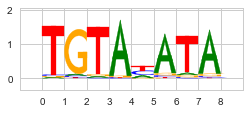

filter index: 1


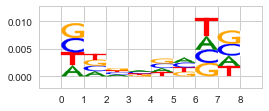

filter index: 2


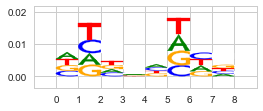

filter index: 3


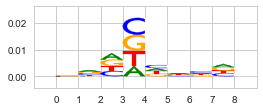

In [52]:
# Convenience layers extend the base class (here keras.layers.Conv1D) with .plot_weights for filter visualization
m.get_layer("conv1").plot_weights(plot_type="motif_pwm_info", figsize=(4, 1.5))

## Used features

### Pre-processing and convenience wrappers

We used `concise.preprocessing.encodeDNA` to convert a list of sequences into a one-hot-encoded array. For each pre-processing function, Concise provides a corresponding Input and Conv1D convenience wrappers. We used the following two in our code:

- `InputDNA` wraps concise.layers.Input and sets the number of channels to 4. 
- `ConvDNA` is a convenience wrapper around Conv1D with the following two modifications:
  - `ConvDNA` checks that the number of input chanels is 4
  - `ConvDNA` has a method for plotting weights: `plot_weights`

Here is a complete list of pre-processors and convenience layers:

|preprocessing| preprocessing type |input layer | convolutional layer| Vocabulary |
|--------------|-------------|-------------|--------------------|------------|
| `encodeDNA` | one-hot| `InputDNA` | `ConvDNA` | `["A", "C", "G", "T"]` |
| `encodeRNA` | one-hot | `InputRNA` | `ConvRNA` | `["A", "C", "G", "U"]` | 
| `encodeCodon` | one-hot, token | `InputCodon` | `ConvCodon` | `["AAA", "AAC", ...]` | 
| `encodeAA`  | one-hot, token| `InputAA` | `ConvAA` | `["A", "R", "N", ...]` |
| `encodeRNAStructure` | probabilities | `InputRNAStructure` | `ConvRNAStructure` | /|
| `encodeSplines` | B-spline basis functions | `InputSplines` | `ConvSplines` | Numerical values|

### PWM initialization

See the PWM initialization notebook in getting-started section of the [concise documentation](https://i12g-gagneurweb.in.tum.de/public/docs/concise/)

### Other features

Check out other notebooks in getting-started section of the [concise documentation](https://i12g-gagneurweb.in.tum.de/public/docs/concise/)

## Plan

Provide additional explaination on each of the presented components

TODO - find a good example dataset for doing this 

Docs plan:
- Getting started
  - brief intro about the features
  - simple case-study
  - explain where to find additional information about the features
  - explain convenience layers and pre-processing
- Features
  - PWM initialization
  - Spline transformation
  - hyper-param optimization
  - SNP effect prediction

## General

CONCISE is a Keras extension providing 

- pre-processing functions standardizing the deep learning workflow, 
- custom Keras components specific for regulatory genomics
  - Layers
  - Initializers
  - Regularizers
- hyper-parameter tuning functionality simplifying the process of selecting the right model architecture and the corresponding parameters.